# Predicting Style Probability by Painting Features

Author: Yangyu Wang, Gio Choi, Avi Oberoi

Date: 02/11/2025

## Table of Contents

1. [Data Preprocessing](#Data-Preprocessing)
2. [Tree-based Model](#Tree-based-Model:-Random-Forest)
3. [Linear Model](#Linear-Model)
4. [Model Comparison & Results](#Model-Comparison-&-Results)

## Data Preprocessing

In [1]:
#Avi, Please add your code here

## EDA

1. Processing data

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [3]:
painting_feature = pd.read_csv("data/artwork_with_clip_features.csv")

In [4]:
def string_to_array(s):
    '''
    Change the string-like array into numpy.array
    Parameter:
        s: string to change with an array structure
    Output: array
    '''
    return np.fromstring(s.strip("[]"), sep=" ").tolist()

painting_feature['Feature_array'] = painting_feature['Feature'].apply(string_to_array)

In [5]:
print(painting_feature['Feature_array'][0][0])

0.035522


In [6]:
len(set(painting_feature["Style_Category"]))

16

In [7]:
painting_feature.head()

,Artwork_ID,Artist_name,Year,image_n,Style_Category,Feature,Feature_array
0,9,a-y-jackson,1919,46467,Impressionism & Post-Impressionism,[ 3.5522e-02 -5.0446e-02 3.7323e-02 1.8173e-...,"[0.035522, -0.050446, 0.037323, 0.018173, -0.0..."
1,10,a-y-jackson,1918,73382,Art Nouveau & Deco,[-2.8248e-03 -2.7283e-02 2.2278e-02 1.8936e-...,"[-0.0028248, -0.027283, 0.022278, 0.018936, -0..."
2,11,a-y-jackson,1951,64112,Impressionism & Post-Impressionism,[ 3.4515e-02 -7.7515e-03 3.0270e-03 1.6342e-...,"[0.034515, -0.0077515, 0.003027, 0.016342, -0...."
3,12,a-y-jackson,1920,2173,Impressionism & Post-Impressionism,[-1.0796e-02 7.4120e-03 1.1635e-02 4.5807e-...,"[-0.010796, 0.007412, 0.011635, 0.045807, 0.00..."
4,13,a-y-jackson,1933,74330,Art Nouveau & Deco,[-1.3092e-02 -1.0653e-03 5.2887e-02 -4.5700e-...,"[-0.013092, -0.0010653, 0.052887, -0.00457, -0..."


Here we do not directly encode the Style_Category, because for tree-based and linear model, y should be encoded in different ways. Detailed processing on the y, please check each part.

2. Visualization

In [8]:
# Avi, could you add some dimension detection on features here?

Visualization by Years and Style categories

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
painting_feature_nondup = painting_feature.drop_duplicates("image_n")

In [11]:
yearly_counts = painting_feature_nondup.groupby("Year").size().reset_index(name="Artwork_Count")

In [12]:
yearly_counts["Year"] = yearly_counts["Year"].astype(int)

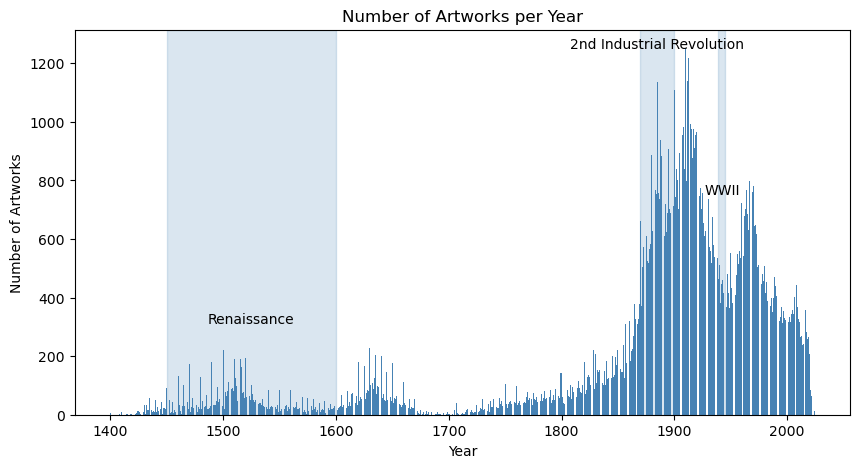

In [13]:
plt.figure(figsize=(10, 5))
ax = plt.bar(data=yearly_counts, x="Year", height="Artwork_Count", color="steelblue")

plt.xlabel("Year")
plt.ylabel("Number of Artworks")
plt.title("Number of Artworks per Year")

plt.axvspan(1450, 1600, color='steelblue', alpha=0.2)
plt.text(1525, yearly_counts["Artwork_Count"].max() * 0.25, "Renaissance", fontsize=10, color="black", ha='center')

plt.axvspan(1870, 1900, color='steelblue', alpha=0.2)
plt.text(1885, yearly_counts["Artwork_Count"].max() * 1, "2nd Industrial Revolution", fontsize=10, color="black", ha='center')

plt.axvspan(1939, 1945, color='steelblue', alpha=0.2)
plt.text(1942.5, yearly_counts["Artwork_Count"].max() * 0.6, "WWII", fontsize=10, color="black", ha='center')

plt.show()

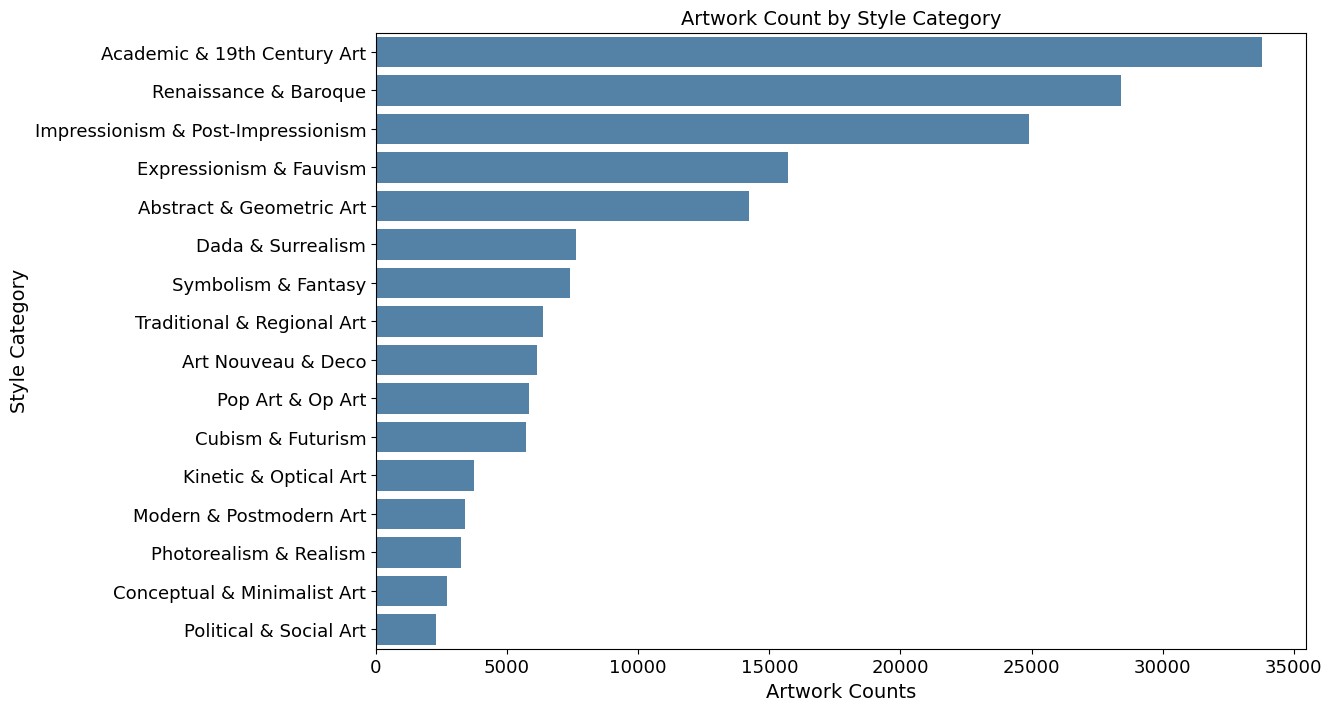

In [14]:
style_counts = painting_feature["Style_Category"].value_counts().reset_index()
style_counts.columns = ["Style_Category", "Count"]

plt.figure(figsize=(12, 8))
sns.barplot(data=style_counts, x="Count", y="Style_Category", color="steelblue")
plt.xlabel("Artwork Counts", fontsize=14)
plt.ylabel("Style Category", fontsize=14)
plt.title("Artwork Count by Style Category", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

3. Split on training and testing dataset

Because of the imbalanced structure of our dataset, we sample 800 for each categories to train the model and 200 to test.

In [15]:
train_samples = []
test_samples = []

for style, group in painting_feature.groupby('Style_Category'):
    train_sample, test_sample = train_test_split(group, train_size=800, test_size=200, random_state=42, stratify=group['Style_Category'])
    
    train_samples.append(train_sample)
    test_samples.append(test_sample)

balanced_train_df = pd.concat(train_samples)
balanced_test_df = pd.concat(test_samples)

In [16]:
len(balanced_train_df)

12800

## Tree-based Model: Random Forest

1. Data processing

We chose label encoder here, for tree-based do not require any additional encoding to deal with tasks.

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
X_train = np.vstack(balanced_train_df["Feature_array"])
y_train = np.array(balanced_train_df['Style_Category'])

X_test = np.vstack(balanced_test_df["Feature_array"])
y_test = np.array(balanced_test_df['Style_Category'])

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (12800, 512), y_train shape: (12800,)
X_test shape: (3200, 512), y_test shape: (3200,)


2. Random Forest & Model Evaluation

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

In [20]:
rfc_base = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
rfc_base.fit(X_train, y_train)
np.round(rfc_base.score(X_test,y_test),3)

0.502

In [21]:
y_pred_rfc_base = rfc_base.predict(X_test)
y_probs_rfc_base = rfc_base.predict_proba(X_test)
confusion_matrix(y_test, y_pred_rfc_base, labels=rfc_base.classes_)

array([[ 87,   0,   2,  18,  10,   9,   5,   0,  47,   2,   5,   2,   7,
          0,   0,   6],
       [  1, 112,  10,   0,   2,   0,   0,  29,   0,   3,   3,   6,   0,
         27,   7,   0],
       [  2,  20,  92,   6,   4,   8,   8,  17,   1,   2,   5,  11,   2,
          6,  13,   3],
       [ 20,   0,   2, 130,   0,   1,   0,   0,   9,   5,   3,   8,  18,
          0,   1,   3],
       [  9,   0,   4,   0, 141,  13,  11,   7,   2,   1,   0,   6,   3,
          0,   2,   1],
       [  8,   2,   8,  11,  33,  74,   8,   2,   9,   5,   2,   8,   8,
          2,  16,   4],
       [  3,   9,  10,   3,  35,   9,  57,  27,   9,  14,   1,   2,   4,
          0,   8,   9],
       [  0,  25,   6,   1,   0,   3,   7, 144,   0,   0,   5,   1,   0,
          2,   5,   1],
       [ 30,   0,   0,  11,   9,   5,   0,   1, 130,   2,   1,   0,  10,
          0,   0,   1],
       [  3,   4,   2,  11,   0,   7,   6,   9,  19,  91,  10,  13,   9,
          3,   7,   6],
       [  1,  13,   4,  10,   

In [22]:
print(classification_report(y_test, y_pred_rfc_base, zero_division=np.nan))

                                    precision    recall  f1-score   support

          Abstract & Geometric Art       0.46      0.43      0.45       200
       Academic & 19th Century Art       0.47      0.56      0.51       200
                Art Nouveau & Deco       0.49      0.46      0.47       200
       Conceptual & Minimalist Art       0.53      0.65      0.59       200
                 Cubism & Futurism       0.53      0.70      0.61       200
                 Dada & Surrealism       0.42      0.37      0.39       200
           Expressionism & Fauvism       0.38      0.28      0.32       200
Impressionism & Post-Impressionism       0.51      0.72      0.60       200
             Kinetic & Optical Art       0.48      0.65      0.55       200
           Modern & Postmodern Art       0.50      0.46      0.48       200
            Photorealism & Realism       0.50      0.36      0.42       200
            Political & Social Art       0.48      0.46      0.47       200
           

In [23]:
roc_score_1 = roc_auc_score(y_test, y_probs_rfc_base, multi_class='ovo')
roc_score_1

0.89542984375

In [24]:
y_test_bin = label_binarize(y_test, classes=rfc_base.classes_)

roc_per_class_1 = roc_auc_score(y_test_bin, y_probs_rfc_base, average=None)

for style, roc in zip(rfc_base.classes_, roc_per_class_1):
    print("ROC-AUC for", style + ":", roc)

ROC-AUC for Abstract & Geometric Art: 0.8992175000000001
ROC-AUC for Academic & 19th Century Art: 0.9222108333333333
ROC-AUC for Art Nouveau & Deco: 0.8974783333333334
ROC-AUC for Conceptual & Minimalist Art: 0.9404508333333333
ROC-AUC for Cubism & Futurism: 0.9324625
ROC-AUC for Dada & Surrealism: 0.8759983333333333
ROC-AUC for Expressionism & Fauvism: 0.8251141666666666
ROC-AUC for Impressionism & Post-Impressionism: 0.9401774999999999
ROC-AUC for Kinetic & Optical Art: 0.9507083333333334
ROC-AUC for Modern & Postmodern Art: 0.8414941666666667
ROC-AUC for Photorealism & Realism: 0.8736308333333332
ROC-AUC for Political & Social Art: 0.8865025
ROC-AUC for Pop Art & Op Art: 0.8442733333333333
ROC-AUC for Renaissance & Baroque: 0.9874491666666667
ROC-AUC for Symbolism & Fantasy: 0.83826
ROC-AUC for Traditional & Regional Art: 0.8714491666666668


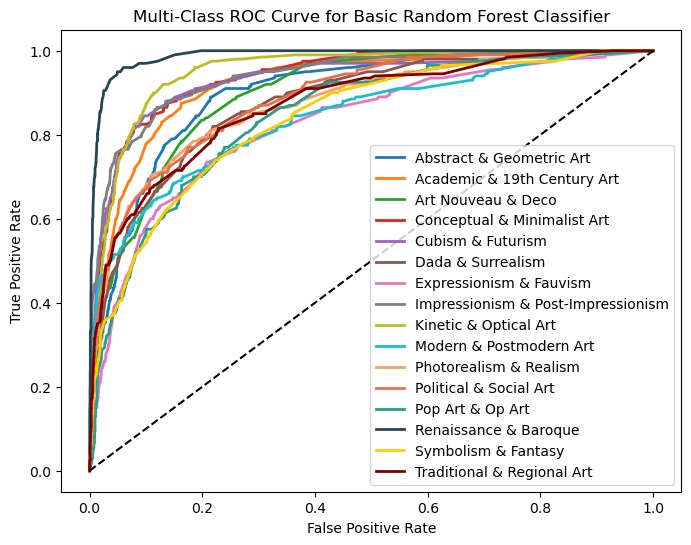

In [25]:
n_classes = len(rfc_base.classes_)

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf", "#f4a261", "#e76f51", "#2a9d8f", "#264653", "#ffcc00", "#800000"
]

plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs_rfc_base[:, i])
    plt.plot(fpr, tpr, lw=2, color=color, label=rfc_base.classes_[i])

plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve for Basic Random Forest Classifier")
plt.legend()
plt.show()

3. Grid search to fine tune the model

We try to change the __max_depth__ (the depth of trees), __max_features__ (maximum number of features used in single tree), and __max_samples__ (maximum number of samples used in single tree).

Here, we focus on the roc-auc of the model, because the model is not used to categorize paintings. Instead, the model is to generate prabilities. As a result, a higher roc-auc means the probabilities between difference labels have higher stratification, which is better for our task.

In [26]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score
from tqdm import tqdm

In [37]:
rfc = RandomForestClassifier(criterion='entropy', random_state=42)

param_grid = {
    'max_depth': [10, 20, None],
    'max_features': [5, 20, None],
    'max_samples': [0.5, 0.8, None]
}

param_list = list(ParameterGrid(param_grid))
print(f"Total parameter combinations: {len(param_list)}")

Total parameter combinations: 27


In [ ]:
best_params = None
best_test_auc = 0
best_rfc = None

param_grid_record = param_grid.copy()

with tqdm(param_list, desc="Grid Search Progress") as pbar:
    for params in pbar:
        rfc = RandomForestClassifier(**params, random_state=42)
        rfc.fit(X_train, y_train)

        y_pred = rfc.predict(X_test)
        y_pred_probs = rfc.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_probs, multi_class="ovo")
        test_accuracy = rfc.score(X_test, y_test)
        test_f1 = f1_score(y_test, y_pred, average='macro')

        param_grid_record["roc-auc"] = param_grid_record.get("roc-auc", []) + [test_auc]
        param_grid_record["accuracy"] = param_grid_record.get("accuracy", []) + [test_accuracy]
        param_grid_record["f1"] = param_grid_record.get("f1", []) + [test_f1]

        if test_auc > best_test_auc:
            best_test_auc = test_auc
            best_params = params
            best_rfc = rfc
        
        pbar.set_postfix({"Best AUC": f"{best_test_auc:.4f}"})
        
        print({"Accuracy": f"{test_accuracy:.4f}", "AUC": f"{test_auc:.4f}"})

print("Best parameters:", best_params)
print(f"Best Test AUC: {best_test_auc:.4f}")

Grid Search Progress:   4%|▎         | 1/27 [00:04<01:56,  4.47s/it, Best AUC=0.8968]

{'Accuracy': '0.4706', 'AUC': '0.8968'}


Grid Search Progress:   7%|▋         | 2/27 [00:10<02:09,  5.17s/it, Best AUC=0.8993]

{'Accuracy': '0.4791', 'AUC': '0.8993'}


Grid Search Progress:  11%|█         | 3/27 [00:16<02:17,  5.74s/it, Best AUC=0.8993]

{'Accuracy': '0.4722', 'AUC': '0.8992'}


Grid Search Progress:  15%|█▍        | 4/27 [00:30<03:28,  9.08s/it, Best AUC=0.8993]

{'Accuracy': '0.4853', 'AUC': '0.8975'}


Grid Search Progress:  19%|█▊        | 5/27 [00:50<04:43, 12.88s/it, Best AUC=0.8995]

{'Accuracy': '0.4888', 'AUC': '0.8995'}


Grid Search Progress:  22%|██▏       | 6/27 [01:12<05:37, 16.08s/it, Best AUC=0.9035]

{'Accuracy': '0.4906', 'AUC': '0.9035'}


Grid Search Progress:  26%|██▌       | 7/27 [06:47<40:03, 120.15s/it, Best AUC=0.9035]

{'Accuracy': '0.4684', 'AUC': '0.8896'}


Grid Search Progress:  30%|██▉       | 8/27 [14:53<1:14:58, 236.78s/it, Best AUC=0.9035]

{'Accuracy': '0.4694', 'AUC': '0.8856'}


Grid Search Progress:  33%|███▎      | 9/27 [23:49<1:39:02, 330.15s/it, Best AUC=0.9035]

{'Accuracy': '0.4641', 'AUC': '0.8848'}


Grid Search Progress:  37%|███▋      | 10/27 [23:55<1:05:14, 230.24s/it, Best AUC=0.9035]

{'Accuracy': '0.4894', 'AUC': '0.8883'}


Grid Search Progress:  41%|████      | 11/27 [24:04<43:18, 162.43s/it, Best AUC=0.9035]  

{'Accuracy': '0.4881', 'AUC': '0.8880'}


Grid Search Progress:  44%|████▍     | 12/27 [24:13<28:58, 115.91s/it, Best AUC=0.9035]

{'Accuracy': '0.4888', 'AUC': '0.8820'}


Grid Search Progress:  48%|████▊     | 13/27 [24:32<20:09, 86.42s/it, Best AUC=0.9035] 

{'Accuracy': '0.5062', 'AUC': '0.8972'}


Grid Search Progress:  52%|█████▏    | 14/27 [24:58<14:48, 68.36s/it, Best AUC=0.9035]

{'Accuracy': '0.5062', 'AUC': '0.8961'}


Grid Search Progress:  56%|█████▌    | 15/27 [25:29<11:24, 57.05s/it, Best AUC=0.9035]

{'Accuracy': '0.5116', 'AUC': '0.8955'}


Grid Search Progress:  59%|█████▉    | 16/27 [32:57<32:01, 174.64s/it, Best AUC=0.9035]

{'Accuracy': '0.4881', 'AUC': '0.8951'}


Grid Search Progress:  63%|██████▎   | 17/27 [43:27<51:54, 311.46s/it, Best AUC=0.9035]

{'Accuracy': '0.4991', 'AUC': '0.8937'}


In [ ]:
np.round(best_rfc.score(X_test,y_test),3)

0.491

In [64]:
y_pred_best_rfc = best_rfc.predict(X_test)
y_probs_best_rfc = best_rfc.predict_proba(X_test)

array([[ 70,   0,   1,  23,  13,   5,   6,   0,  56,   5,   3,   1,  12,
          0,   3,   2],
       [  0, 114,   9,   1,   0,   2,   3,  28,   1,   1,   4,   3,   2,
         29,   3,   0],
       [  1,  21,  89,   8,   5,   7,   5,  20,   2,   2,   2,  12,   2,
          5,  15,   4],
       [ 17,   0,   4, 134,   1,   1,   0,   0,   8,   2,   4,   8,  18,
          0,   1,   2],
       [  8,   0,   3,   3, 142,  12,  14,   5,   7,   0,   0,   2,   2,
          0,   2,   0],
       [  4,   3,   5,  17,  40,  71,   7,   3,  19,   4,   3,   6,   5,
          5,   5,   3],
       [  1,   6,   8,   4,  37,  10,  60,  24,  14,  11,   0,   5,   7,
          0,   9,   4],
       [  0,  23,   7,   0,   2,   0,   9, 144,   1,   0,   4,   1,   0,
          1,   7,   1],
       [ 24,   0,   0,  10,  10,   5,   1,   0, 140,   2,   1,   0,   6,
          0,   0,   1],
       [  6,   2,   5,  22,   0,   5,   5,  13,  25,  77,  12,  12,   4,
          4,   3,   5],
       [  3,  15,   1,  13,   

In [65]:
print(classification_report(y_test, y_pred_best_rfc, zero_division=np.nan))

                                    precision    recall  f1-score   support

          Abstract & Geometric Art       0.42      0.35      0.38       200
       Academic & 19th Century Art       0.48      0.57      0.52       200
                Art Nouveau & Deco       0.48      0.45      0.46       200
       Conceptual & Minimalist Art       0.47      0.67      0.55       200
                 Cubism & Futurism       0.50      0.71      0.59       200
                 Dada & Surrealism       0.45      0.35      0.40       200
           Expressionism & Fauvism       0.40      0.30      0.34       200
Impressionism & Post-Impressionism       0.48      0.72      0.58       200
             Kinetic & Optical Art       0.43      0.70      0.53       200
           Modern & Postmodern Art       0.49      0.39      0.43       200
            Photorealism & Realism       0.55      0.34      0.42       200
            Political & Social Art       0.48      0.46      0.47       200
           

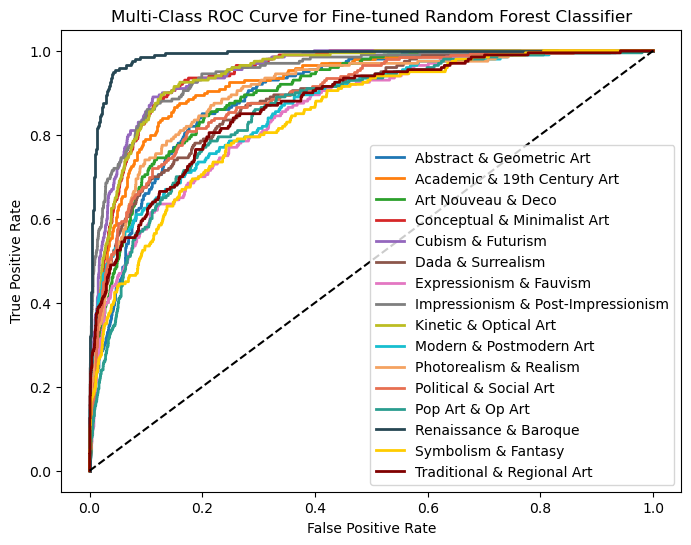

In [66]:
n_classes = len(best_rfc.classes_)

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf", "#f4a261", "#e76f51", "#2a9d8f", "#264653", "#ffcc00", "#800000"
]

plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs_best_rfc[:, i])
    plt.plot(fpr, tpr, lw=2, color=color, label=best_rfc.classes_[i])

plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve for Fine-tuned Random Forest Classifier")
plt.legend()
plt.show()

3. Interpretation: Visualize the first tree

In [ ]:
import graphviz 
from sklearn import tree

In [ ]:
# set names
feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]
unique_classes = np.unique(y_train)
class_names = [str(cls) for cls in unique_classes]

In [ ]:
# try on the first tree
best_tree_example0 = best_rfc.estimators_[0]

In [ ]:
dot_data0 = tree.export_graphviz(best_tree_example0, out_file=None, 
                                feature_names=feature_names, 
                                class_names=class_names,  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph0 = graphviz.Source(dot_data0)  
graph0 

In [ ]:
tree_dict = {}

for i in range(len(best_rfc.estimators_[:5])):
    tree_case = best_rfc.estimators_[i]
    dot_data = tree.export_graphviz(tree_case, out_file=None, 
                                feature_names=feature_names, 
                                class_names=class_names,  
                                filled=True, rounded=True,  
                                special_characters=True)  
    graph = graphviz.Source(dot_data)  
    tree_dict[i] = graph

4. Error analysis

In [ ]:
cf_matrix_best_rfc = confusion_matrix(y_test, y_pred_best_rfc, labels=best_rfc.classes_)

In [ ]:
sns.heatmap(cf_matrix_best_rfc/np.sum(cf_matrix_best_rfc), annot=True, 
            fmt='.2%', cmap='Blues')

## Linear Model

## Model-Comparison-&-Results